# Intro/Imports
This is an adaptation of nnExpPreds that will allow for adaptive changing of starting conditions, generating a set of model predictions to match.

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import joblib
import pathlib as path
import copy
import random

# Model Import

In [10]:
model = torch.load('models/model.pt')
model.eval()
#loss/optimizer
loss_fn = nn.MSELoss() #Mean Squared Error
optimizer = optim.Adam(model.parameters(), lr=0.0005)

#scalers
mmscalerX = joblib.load('models/mmscalerX.pkl')
mmscalerY = joblib.load('models/mmscalerY.pkl')


# Initial Condition Prep
The prediction loop works by iterating thru a dataframe; feeding the current row through the model, and replacing the values of the next row with the results from the model. 
- X is a dataframe with rows: C_X, C_N, C_L, F_in, C_N_in, I0, and Time
- Y is a dataframe with rows C_X, C_N, C_L

In [11]:
XTimes = np.linspace(0, 150, 200)
XDF = pd.DataFrame(XTimes, columns=['Time'])
#generate empty columns
XDF['C_X'] = np.zeros(200)
XDF['C_N'] = np.zeros(200)
XDF['C_L'] = np.zeros(200)
XDF['F_in'] = np.zeros(200)
XDF['C_N_in'] = np.zeros(200)
XDF['I0'] = np.zeros(200)
XTimes = XDF.pop('Time')
#set initial conditions by changing these vals
C_X_init = 1
C_N_init = 1
C_L_init = 0.0
F_in_init = 0.005
C_N_in_init = 10
I0_init = 150
#write init conditions to df
XDF['C_X'][0] = C_X_init
XDF['C_N'][0] = C_N_init
XDF['C_L'][0] = C_L_init
XDF['F_in'] = F_in_init
XDF['C_N_in'] = C_N_in_init
XDF['I0'] = I0_init

#loop through the experiment and predict each timestep
for i in range(0, 199):
    #get the current timestep
    X_current = XDF.iloc[i]
    #scale the current timestep
    X_current_scaled = mmscalerX.transform([X_current])
    #predict the next timestep
    Y_current_scaled = model(torch.tensor(X_current_scaled, dtype=torch.float32))
    #unscale the prediction
    Y_current_scaled = Y_current_scaled.detach().numpy()
    Y_current = mmscalerY.inverse_transform(Y_current_scaled)
    #store the prediction
    nextTimeStep = i+1
    XDF.iloc[nextTimeStep, 0] = Y_current[0,0]
    XDF.iloc[nextTimeStep, 1] = Y_current[0,1]
    XDF.iloc[nextTimeStep, 2] = Y_current[0,2]
    print(XDF.iloc[nextTimeStep])


C_X         1.033799
C_N         1.169809
C_L         0.000106
F_in        0.005000
C_N_in     10.000000
I0        150.000000
Name: 1, dtype: float64
C_X         1.069476
C_N         1.340492
C_L         0.000198
F_in        0.005000
C_N_in     10.000000
I0        150.000000
Name: 2, dtype: float64
C_X         1.104856
C_N         1.480868
C_L         0.000288
F_in        0.005000
C_N_in     10.000000
I0        150.000000
Name: 3, dtype: float64
C_X         1.139823
C_N         1.592861
C_L         0.000378
F_in        0.005000
C_N_in     10.000000
I0        150.000000
Name: 4, dtype: float64
C_X         1.174530
C_N         1.681996
C_L         0.000468
F_in        0.005000
C_N_in     10.000000
I0        150.000000
Name: 5, dtype: float64
C_X         1.209100
C_N         1.752721
C_L         0.000559
F_in        0.005000
C_N_in     10.000000
I0        150.000000
Name: 6, dtype: float64
C_X         1.243631
C_N         1.808622
C_L         0.000650
F_in        0.005000
C_N_in     10.00

C:\Users\kenda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\kenda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\kenda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\kenda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:439: UserWarning: X doe

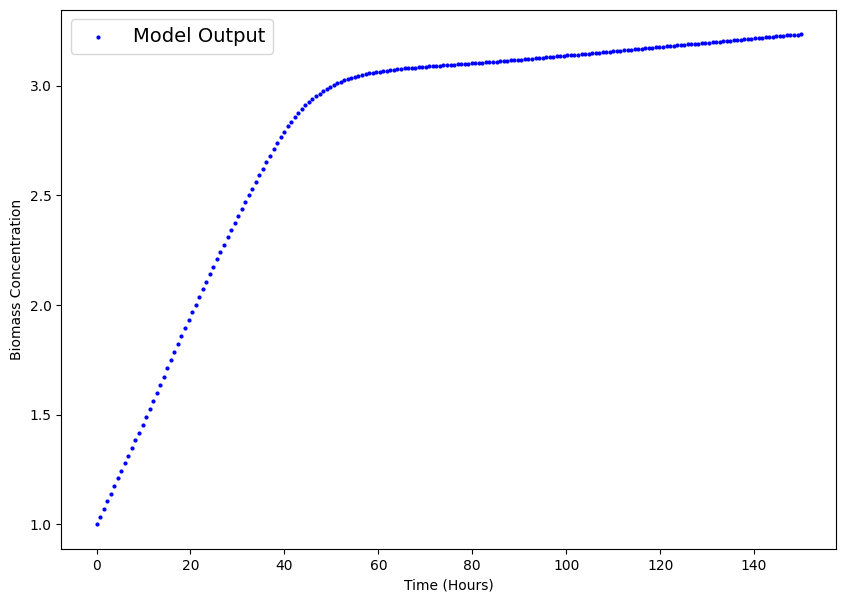

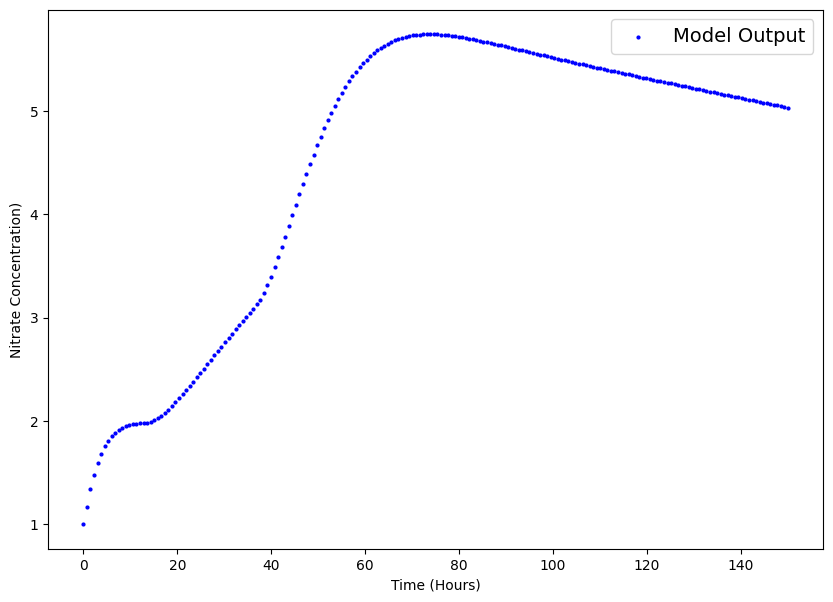

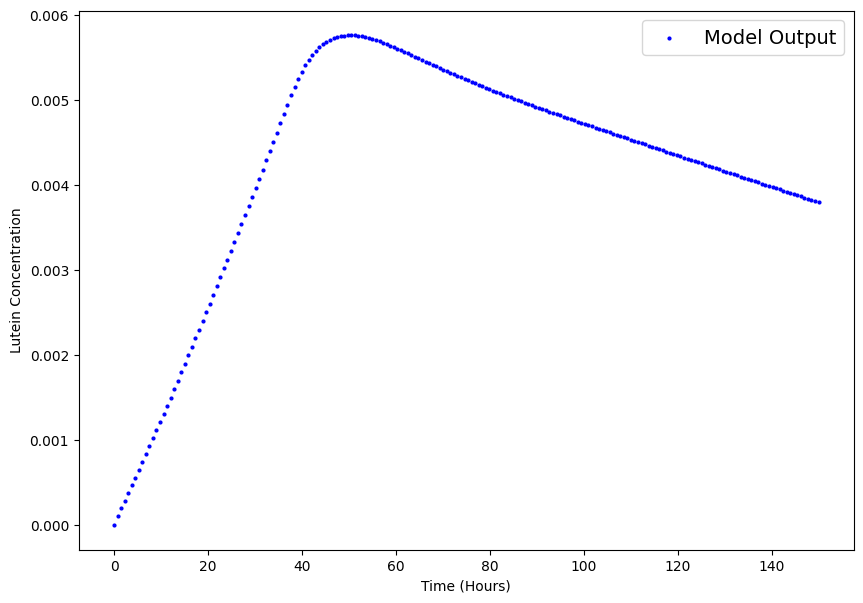

In [12]:
col = 0
#quick visual just to see our data
def plot_predictions(col = col,
                     train_data=XTimes, 
                     train_labels=XDF):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7)) #create the base of our figure, figsize feeds in width/height in inches

  # Plot training data in blue
  plt.scatter(train_data, train_labels.iloc[:, col], c="b", s=4, label="Model Output") #c for color, s for size. 

  # Show the legend
  plt.legend(prop={"size": 14});
  #Axes labels
  plt.xlabel("Time (Hours)")
  match col:
    case 0:
      plt.ylabel("Biomass Concentration")
    case 1:
      plt.ylabel("Nitrate Concentration)")
    case 2:
      plt.ylabel("Lutein Concentration")

plot_predictions(col=0)
plot_predictions(col=1)
plot_predictions(col=2)